# Proyecto 2: Procesamiento de lenguaje natural con tweets de desastres

- Marco Fuentes - 18188
- Andy Castillo - 18040
- Francisco Rosal - 18676
- Gian Luca Rivera - 18049

## Situación problemática
Hoy en día las redes sociales son un medio de comunicación que utilizan la mayoría de personas en todo el mundo en su día a día. Considerando las redes sociales nos permiten para transmitir un mensaje de forma sencilla y el gran alcance que tienen, las redes sociales pueden ser una fuente de información muy importante. Estas pueden ser muy útiles al momento de querer informar sobre alguna situtación crítica, como en este caso algún desastre, ya sea natural o provocado, en donde se necesita que las personas estén informadas lo más rápido posible. No todas las redes sociales están diseñadas para poder informar de una forma tan rápida, sin embargo redes sociales como twitter si nos pueden ayudar a este propósito.

## Problema científico
Twitter se ha convertido en un importante canal de comunicación en tiempos de emergencia. La ubicuidad de los teléfonos inteligentes permite a las personas anunciar una emergencia que están observando en tiempo real. Debido a esto, más agencias (organizaciones de socorro, agencias de noticias) están interesadas en monitorear programáticamente Twitter, sin embargo, no siempre está claro si las palabras de una persona realmente anuncian un desastre.


## Objetivo general
- Crear modelos de aprendizaje automático que permita predecir qué tweets son sobre desastres reales y cuáles no.

## Objetivos específicos
- Analizar los tweets para poder diferenciar entre los que son sobre desastres y los que no.
- Probar diferentes algoritmos con diferentes parámetros para determinar cuales son los modelos más precisos.


## Librerias

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS

## Datos

In [73]:
data = pd.read_csv("train.csv")

## Limpieza y preprocesamiento

Verificamos si hay tweets duplicados.

In [74]:
duplicated_data = data['text'].duplicated().sum()
print(f'Existen {duplicated_data} tweets duplicados')

Existen 110 tweets duplicados


Eliminamos los tweets duplicados ya que representan una pequeña parte del total de tweets.

In [75]:
data = data.drop_duplicates(subset=['text'], keep='first')

Convertimos todo el texto del tweet a minuscula, eliminamos los hipervinculos y caracteres especiales para que no esten las menciones ni los hashtag.

In [76]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'http[s]?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = " ".join(text.split())
    return text

In [77]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )

    return emoji_pattern.sub(r'', text)

In [78]:
data['text'] = data['text'].apply(clean_data)

In [79]:
data['text'] = data['text'].apply(remove_emojis)

In [80]:
data['location'] = data['location'].replace({
    "United States": "USA",
    "London, UK": "UK",
    "Atlanta, GA": "Atlanta",
    "New York City": "New York",
    "NYC": "New York",
    "San Francisco, CA": "San Francisco",
    "California, USA": "California",
    "Chicago, IL": "Chicago",
    "Los Angeles, CA": "Los Angeles",
    "New York, NY": "New York",
    "United Kingdom": "UK",
    "London, England": "London",
    "Everywhere": "Worldwide",
    "Earth": "Worldwide"
})

## Análisis exploratorio

### Dataset general

In [81]:
rows = len(data)
columns = len(data.columns)
print("Columnas: ", columns, " | ", "Filas: ", rows)

Columnas:  5  |  Filas:  7503


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


In [83]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


### Keyword

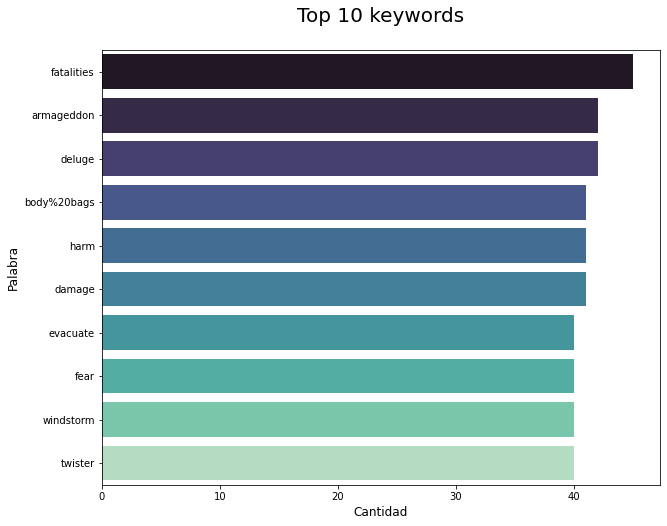

In [84]:
keywords = data['keyword'].value_counts().nlargest(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=keywords.tolist(), y=keywords.index, orient='h', palette='mako')
plt.title('Top 10 keywords\n', fontsize=20)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Palabra', fontsize=12)
plt.show()

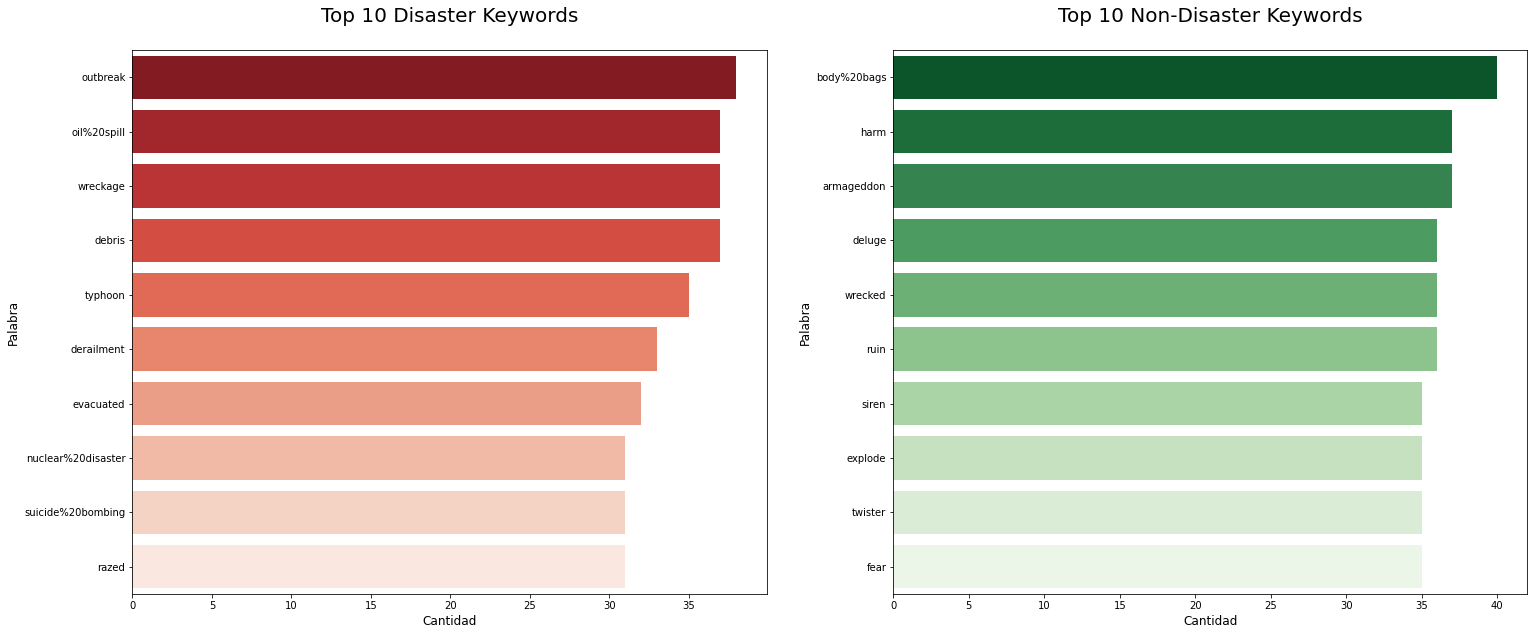

In [85]:
disaster_keywords = data[data['target']==1]['keyword'].value_counts().nlargest(10)
non_disaster_keywords = data[data['target']==0]['keyword'].value_counts().nlargest(10)

fig, ax = plt.subplots(1,2, figsize=(25,10))
sns.barplot(x=disaster_keywords.tolist(), y=disaster_keywords.index, orient='h', palette='Reds_r', ax=ax[0])
sns.barplot(x=non_disaster_keywords.tolist(), y=non_disaster_keywords.index, orient='h', palette='Greens_r', ax=ax[1])

ax[0].set_title('Top 10 Disaster Keywords\n', fontsize=20)
ax[0].set_xlabel('Cantidad', fontsize=12)
ax[0].set_ylabel('Palabra', fontsize=12)

ax[1].set_title('Top 10 Non-Disaster Keywords\n', fontsize=20)
ax[1].set_xlabel('Cantidad', fontsize=12)
ax[1].set_ylabel('Palabra', fontsize=12)
plt.show()

### Location

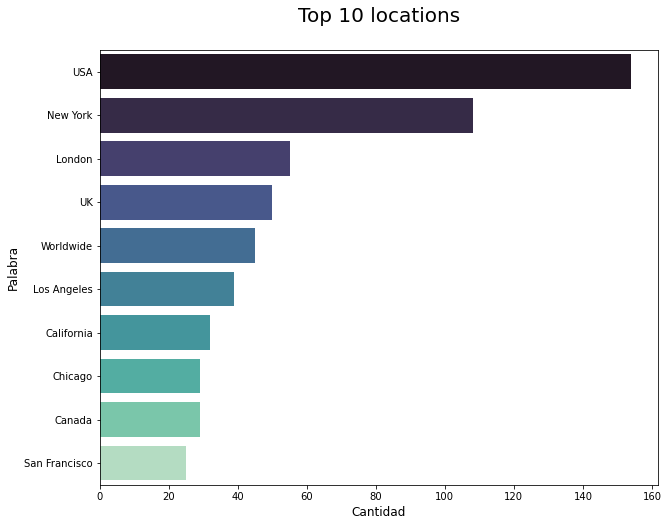

In [86]:
locations = data['location'].value_counts().nlargest(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=locations.tolist(), y=locations.index, orient='h', palette='mako')
plt.title('Top 10 locations\n', fontsize=20)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Palabra', fontsize=12)
plt.show()

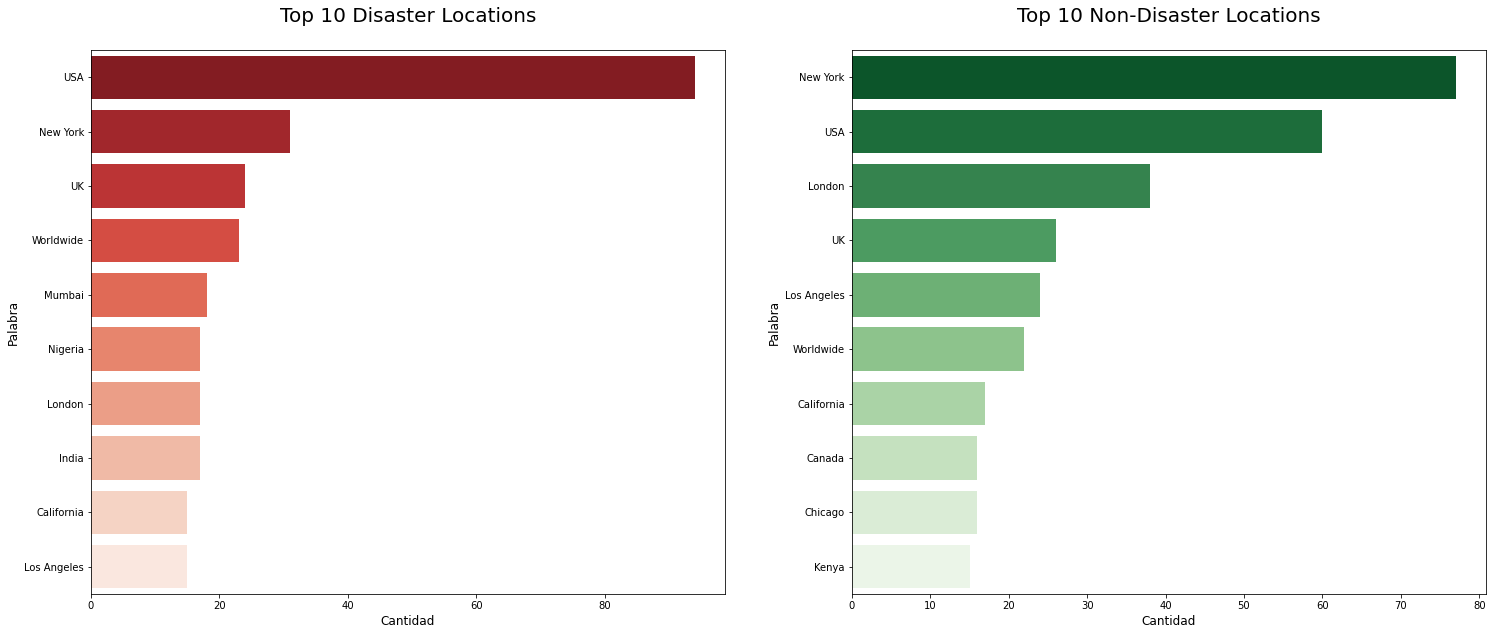

In [87]:
disaster_locations = data[data['target']==1]['location'].value_counts().nlargest(10)
non_disaster_locations = data[data['target']==0]['location'].value_counts().nlargest(10)

fig, ax = plt.subplots(1,2, figsize=(25,10))
sns.barplot(x=disaster_locations.tolist(), y=disaster_locations.index, orient='h', palette='Reds_r', ax=ax[0])
sns.barplot(x=non_disaster_locations.tolist(), y=non_disaster_locations.index, orient='h', palette='Greens_r', ax=ax[1])

ax[0].set_title('Top 10 Disaster Locations\n', fontsize=20)
ax[0].set_xlabel('Cantidad', fontsize=12)
ax[0].set_ylabel('Palabra', fontsize=12)

ax[1].set_title('Top 10 Non-Disaster Locations\n', fontsize=20)
ax[1].set_xlabel('Cantidad', fontsize=12)
ax[1].set_ylabel('Palabra', fontsize=12)
plt.show()

### Text

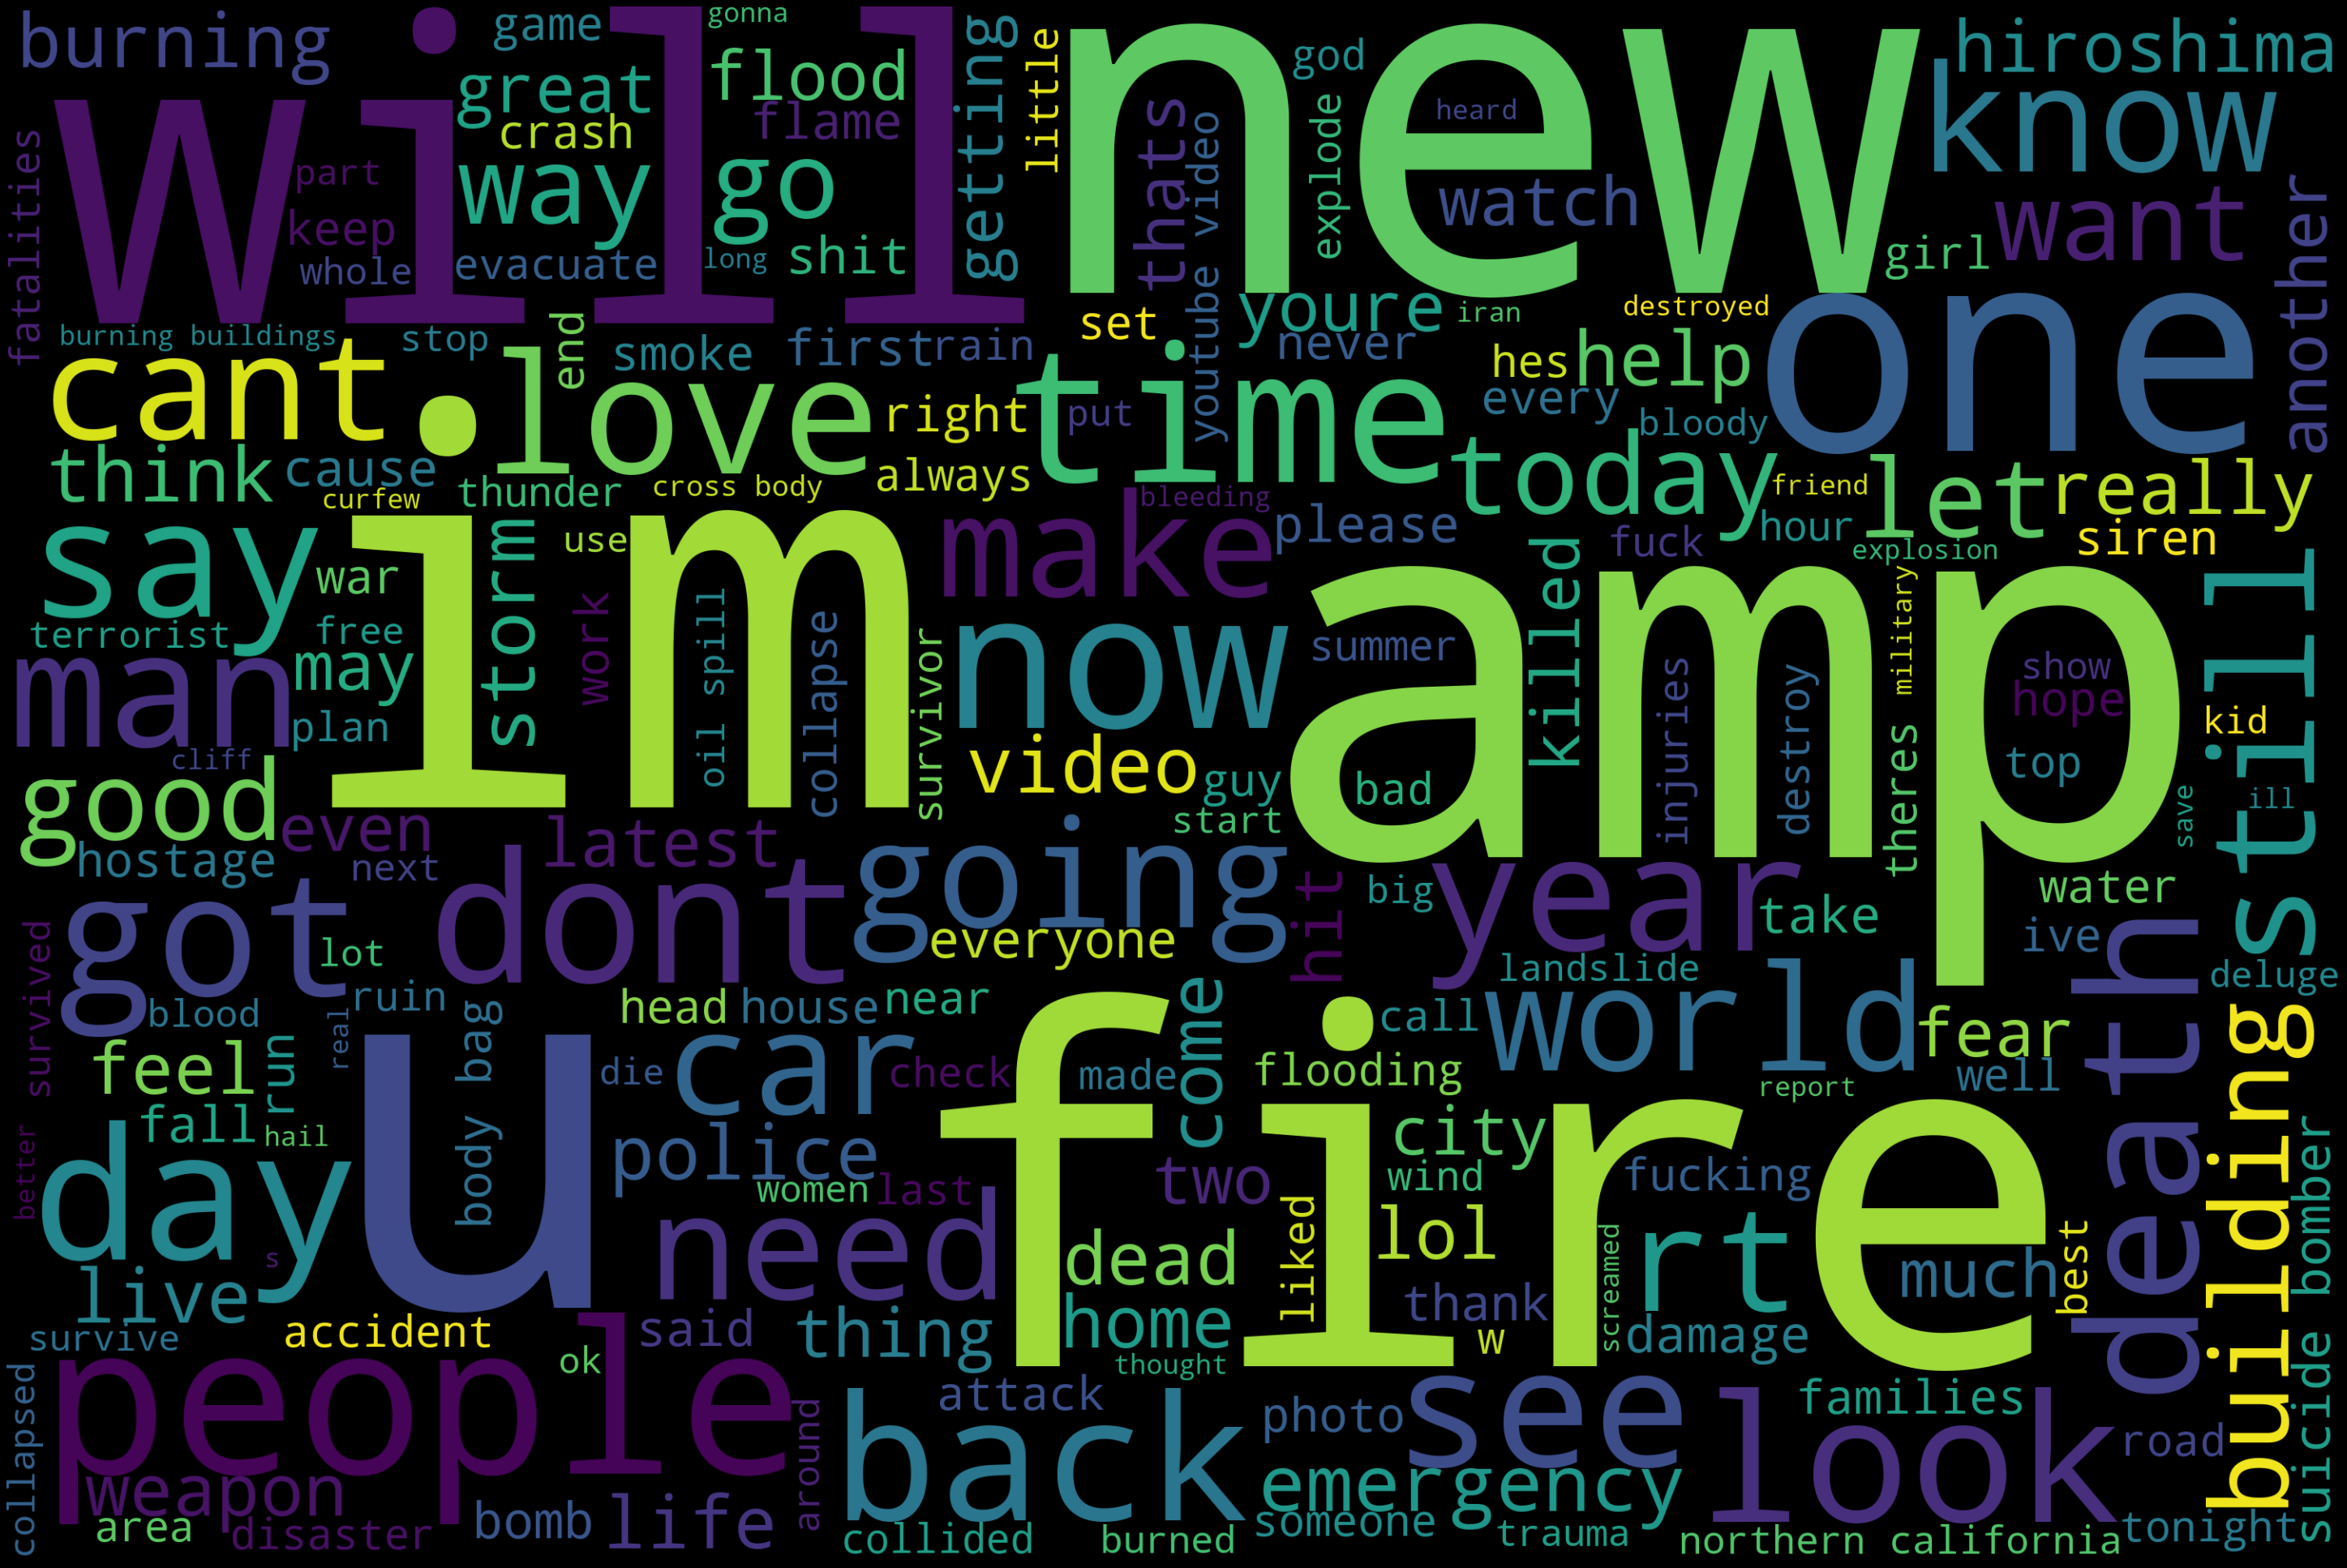

In [88]:
tweets_text = data['text'].str.split(' ')
tweet_data = [" ".join(tweet) for tweet in tweets_text]
all_texts = " ".join(tweet_data)

wordcloud_text = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(all_texts)


fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_text, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

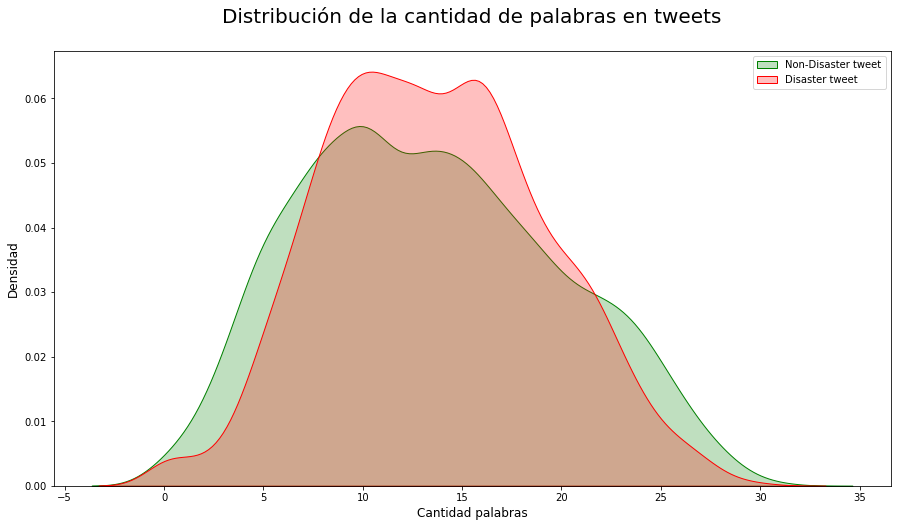

In [89]:
word_count = data['text'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(word_count[data['target'] == 0], shade = True, label = 'Non-Disaster tweet', color='Green')
sns.kdeplot(word_count[data['target'] == 1], shade = True, label = 'Disaster tweet', color='Red')

plt.title('Distribución de la cantidad de palabras en tweets\n', fontsize=20)
ax.legend()
plt.xlabel('Cantidad palabras', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

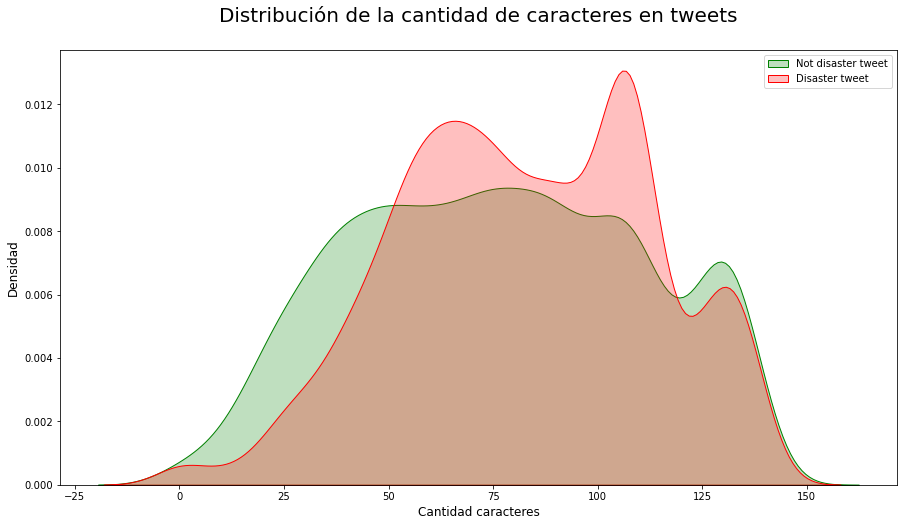

In [90]:
character_count = data['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(character_count[data['target'] == 0], shade = True, label = 'Not disaster tweet', color='Green')
sns.kdeplot(character_count[data['target'] == 1], shade = True, label = 'Disaster tweet', color='Red')

plt.title('Distribución de la cantidad de caracteres en tweets\n', fontsize=20)
ax.legend()
plt.xlabel('Cantidad caracteres', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

### Target

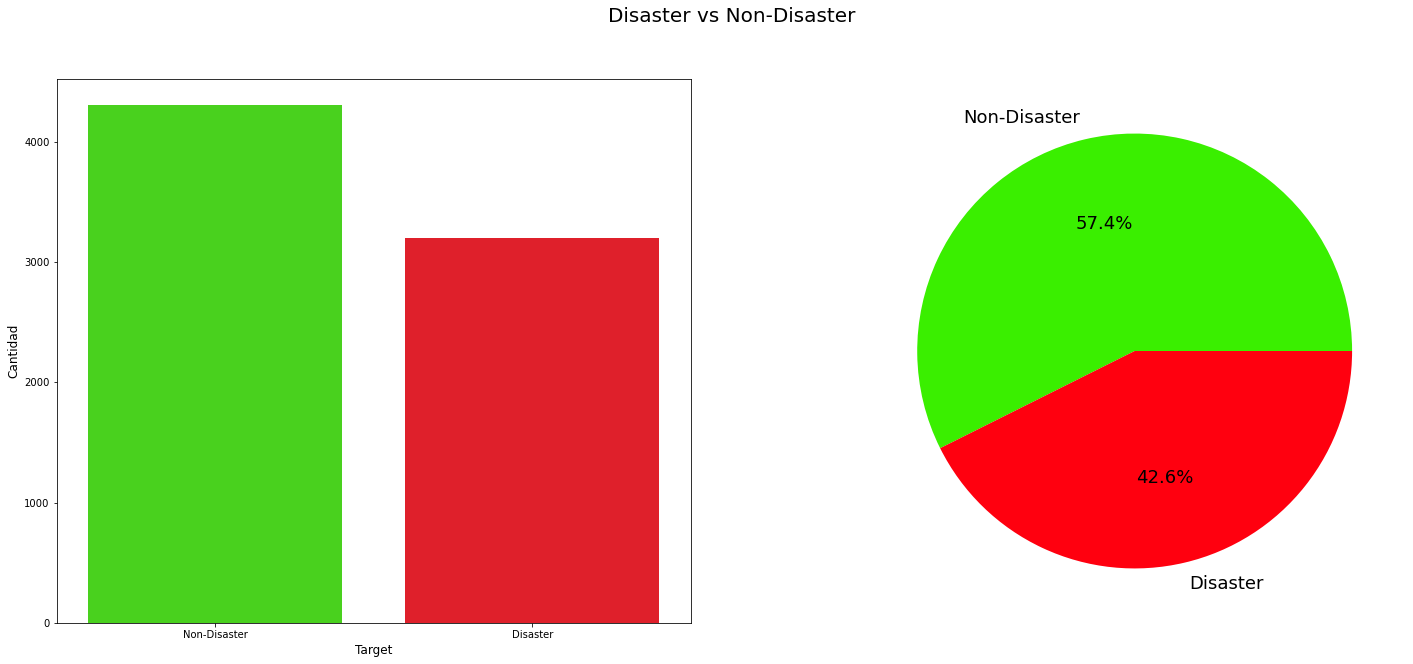

In [91]:
target_values = ['Non-Disaster', 'Disaster']
target = data['target'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(25,10))
fig.suptitle('Disaster vs Non-Disaster', fontsize=20)
colors = sns.color_palette('prism')

sns.barplot(x=target_values, y=target, palette=colors, ax=ax[0])
data.groupby('target').count()['id'].plot(kind='pie', ax=ax[1], labels=target_values, autopct="%.1f%%", colors = colors, fontsize=18)

ax[0].set_xlabel('Target', fontsize=12)
ax[0].set_ylabel('Cantidad', fontsize=12)
ax[1].set_ylabel('')

plt.show()